# [DRAFT] Large-Scale Non-linear Dynamical System 

This notebook does not perform any becnhmark and simply runs the inference procedure and generates some nice plots for the thesis.

Note: This notebook is a draft, the real experiments are in the `notebooks/` folder

_Author: Dmitry Bagaev_

In [1]:
using DrWatson

In [2]:
@quickactivate "RxInferThesisExperiments"

In [3]:
using RxInferThesisExperiments, Turing, StaticArrays, Plots, PGFPlotsX, LaTeXStrings, ReverseDiff
using LinearAlgebra, StableRNGs, Random, BenchmarkTools, ColorSchemes, Dates

In [4]:
# For the thesis I use the `pgfplotsx` backend of the `Plots`, since it generates high-quiality plots
# But it is reallyyy slow, if some wants to generate plots faster uncoment the `gr()` line
# pgfplotsx()

# Use fast plotting backend
gr()

Plots.GRBackend()

## Double pendulum environment

In [5]:
# Create default environment with default parameters
const environment = DoublePendulum()

DoublePendulum()

In [6]:
# Define state-transition function, uses RK4 method internally, see the `src/` folder
f(state) = state_transition(environment)(state)

f (generic function with 1 method)

In [7]:
# Include the model specification
include(srcdir("models", "turing", "doublependulum.jl"));

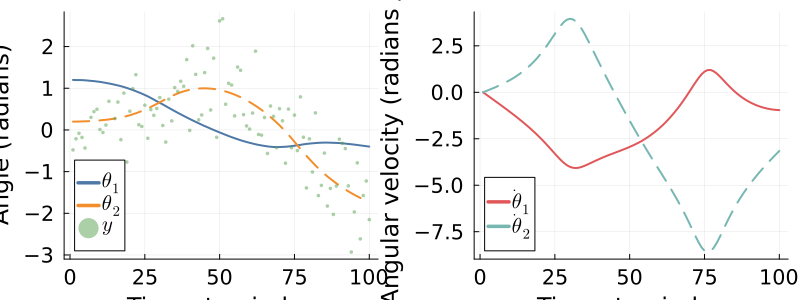

In [255]:
# For plotting purposes I only generate 250 points
T = 100
seed = 43
rng = StableRNG(seed)

states, observations = rand(rng, environment, T; random_start = false);

# `plotting`range
prange = firstindex(states):lastindex(states)
colors = ColorSchemes.tableau_10

# Some default settings for plotting
pfontsettings = (
    titlefontsize=18,
    guidefontsize=16,
    tickfontsize=14,
    legendfontsize=14,
    legend = :bottomleft,
    size = (400, 300)
)

p1 = plot(xlabel = "Time step index", ylabel = "Angle (radians)"; pfontsettings...)
p1 = plot!(prange, getindex.(states, 1)[prange], color = colors[1], linewidth = 2, label = L"\theta_1")
p1 = plot!(p1, prange, getindex.(states, 2)[prange], color = colors[2], linewidth = 2, label = L"\theta_2", style = :dash)
p1 = scatter!(p1, prange, observations[prange], ms = 2, msw = 0, color = colors[5], alpha = 0.5, label = L"y")

p2 = plot(xlabel = "Time step index", ylabel = "Angular velocity (radians / s)"; pfontsettings...)
p2 = plot!(p2, prange, getindex.(states, 3)[prange], color = colors[3], linewidth = 2, label = L"\dot{\theta}_1")
p2 = plot!(p2, prange, getindex.(states, 4)[prange], color = colors[4], linewidth = 2, label = L"\dot{\theta}_2", style = :dash)

plot(p1, p2, layout = @layout([ a b ]), size = (800, 300))

In [256]:
tgmodel = double_pendulum(observations, T);

In [215]:
results = sample_inference(tgmodel, method = NUTS(), nsamples = 100);

┌ Info: Found initial step size
└   ϵ = 0.00302734375
Sampling: 100%|█████████████████████████████████████████| Time: 0:15:41


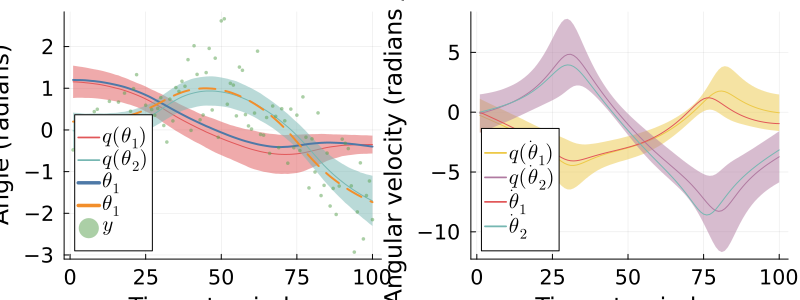

In [216]:
posteriors = extract_posteriors(T, results)

em = mean.(posteriors)
ev = std.(posteriors)

p1 = plot(xlabel = "Time step index", ylabel = "Angle (radians)"; pfontsettings...)

plot!(prange, getindex.(em, 1)[prange], color = colors[3], ribbon = 3getindex.(ev, 1, 1), label = L"q(\theta_1)")
plot!(prange, getindex.(em, 2)[prange], color = colors[4], ribbon = 3getindex.(ev, 2, 2), label = L"q(\theta_2)")
plot!(prange, getindex.(states, 1)[prange], label = L"\theta_1", color = colors[1], linewidth = 2,)
plot!(prange, getindex.(states, 2)[prange], label = L"\theta_1", color = colors[2], linewidth = 2, style = :dash)
scatter!(prange, getindex.(observations, 1)[prange], ms = 2, msw = 0, alpha = 0.5, color = colors[5], label = L"y")

p2 = plot(size=(800, 300), xlabel = "Time step index", ylabel = "Angular velocity (radians / s)"; pfontsettings...)
plot!(prange, getindex.(em, 3)[prange], ribbon = 3getindex.(ev, 3, 3), color = colors[6], label = L"q(\dot{\theta}_1)")
plot!(prange, getindex.(em, 4)[prange], ribbon = 3getindex.(ev, 4, 4), color = colors[7], label = L"q(\dot{\theta}_2)")
plot!(prange, getindex.(states, 3)[prange], color = colors[3], label = L"\dot{\theta}_1")
plot!(prange, getindex.(states, 4)[prange], color = colors[4], label = L"\dot{\theta}_2")

plot(p1, p2, size = (800, 300), layout = @layout([ a b ]))

In [75]:
using StatsFuns, AdvancedVI, StatsBase

In [76]:
import ReactiveMP

In [110]:
Turing.setadbackend(:reversediff)

:reversediff

In [257]:
# function logπ(θ) 
#     error(1)
#     @inbounds σ = abs(θ[1])
#     s = []
#     for t in 1:T
#          @views push!(s, θ[(2 + (t - 1) * 4):(2 + t * 4 - 1)])
#     end
#     loglikelihood(StableRNG(123), tgmodel, (σ = σ, s = s, ))
# end

# function getq(θ)
#     @views μ = θ[1:(4T + 1)]
#     @views v = θ[(4T + 2):(4T + 2 + 4T)]
#     @views od = θ[(4T + 2 + 4T + 1):(4T + 2 + 4T + 4T)]
#     # @views od = -0.1 * abs.(v) # θ[(4T + 2 + 4T + 1):(4T + 2 + 4T + 4T)]
    
#     M = Matrix(SymTridiagonal(collect(v), -1 * collect(v)))
        
#     # return M
    
#     d = Turing.DistributionsAD.TuringDenseMvNormal(μ, ReactiveMP.fastcholesky(M))
#     # d = MvNormal(μ, ReactiveMP.fastcholesky(M))
#     # d = Turing.DistributionsAD.TuringDiagMvNormal(μ, v)

#     varinfo = DynamicPPL.VarInfo(tgmodel)        
    
#     # Construct the bijector constrained → unconstrained.
#     b = Turing.Bijectors.bijector(tgmodel; varinfo=varinfo)

#     # We want to transform from unconstrained space to constrained,
#     # hence we need the inverse of `b`.
#     return Turing.Bijectors.transformed(d, Bijectors.inverse(b))
# end

# function initθ(T) 
#    θ = Vector{Float64}(undef, 4T + 2 + 4T + 4T) 
#    θ[1] = one(Float64)
#    θ[2:(4T + 1)] .= randn(Float64, length(2:(4T + 1)))
#    θ[(4T + 2):(4T + 2 + 4T)] .= one(Float64)
#    θ[(4T + 2 + 4T + 1):(4T + 2 + 4T + 4T)] .= 0.1one(Float64)
#    return θ
# end

In [258]:
function vi_inference(tgmodel; alg = Turing.ADVI())
    # q = Turing.Variational.meanfield(tgmodel)
    return vi(tgmodel, alg, structured(tgmodel))
end

vi_inference (generic function with 1 method)

In [259]:
using LoopVectorization

In [260]:
?Base.Fix2

```
Fix2(f, x)
```

A type representing a partially-applied version of the two-argument function `f`, with the second argument fixed to the value "x". In other words, `Fix2(f, x)` behaves similarly to `y->f(y, x)`.


In [550]:
function fastcholesky_tridiag!(dv, ev)
    
    a = dv
    b = ev
    
    # @inbounds dv[1] = a[1]
    @inbounds for i in 2:length(dv)
        # dv[i] = a[i] - (b[i - 1])^2 / (dv[i - 1])
        dv[i] = max(a[i] - (b[i - 1])^2 / (dv[i - 1]), 0.01)
    end
    
    dv = map!(sqrt, dv, dv)
    ev = map!(/, ev, ev, dv)

    return Cholesky(Bidiagonal(dv, ev, :L), 'L', 0)
end

function fastcholesky_tridiag(dv, ev)
    
    a = ReverseDiff.value(dv)
    b = ReverseDiff.value(ev)
    
    ndv = zeros(length(dv))
    nev = zeros(length(ev))
    
    @inbounds ndv[1] = a[1]
    @inbounds for i in 2:length(dv)
        ndv[i] = a[i] - (b[i - 1])^2 / (ndv[i - 1])
        # ndv[i] = max(a[i] - (b[i - 1])^2 / (ndv[i - 1]), 0.01)
    end
    
    ndv = sqrt.(ndv)
    nev = nev ./ view(ndv, firstindex(nev):lastindex(nev))

    return Cholesky(Bidiagonal(ndv, nev, :L), 'L', 0)
end

fastcholesky_tridiag (generic function with 2 methods)

In [551]:
function ftransformθ(θ)
    l = div(length(θ) + 1, 3)
    p1, p2, p3 = θ[1:l], θ[(l + 1):2l], θ[(2l + 1):end]    
    μ = p1
    offσs = p3
    σs = softplus.(p2)
#     σs = vcat(σs[begin:end-1] .+ 2abs2.(2offσs), σs[end])
#     σs = vcat(σs[begin], σs[begin+1:end] .+ 2abs2.(2offσs))
    
    return μ, σs, offσs
end

function btransformθ(q)
    d = q.dist
    μ = d.m
    L = d.C.L
    C = L * L'
            
    σs = diag(C)
    offσs = diag(C, 1)
    
    # @show σs |> sum
    
    p1 = μ
    p3 = offσs
    p2 = σs
    p2[begin:end-1] .-= 2abs2.(2offσs)
    p2[begin+1:end] .-= 2abs2.(2offσs)
    p2 = invsoftplus.(p2)
    
    l = length(μ)
    θ = zeros(3l - 1)
    θ[1:l] .= p1
    θ[(l + 1):2l] .= p2
    θ[(2l + 1):end] .= p3
    
    return θ
end

# for i in 1:5000
#     θ = randn(299)
#     μ, σs, offσs = ftransformθ(θ);
#     M = SymTridiagonal(σs, offσs)
    
#     if !isposdef(M)
#         error()
#     end
    
#     C = fastcholesky_tridiag!(SymTridiagonal(σs, offσs))
        
#     d = Turing.DistributionsAD.TuringDenseMvNormal(μ, C)

#     varinfo = DynamicPPL.VarInfo(tgmodel)
    
#     # Construct the bijector constrained → unconstrained.
#     b = Bijectors.bijector(tgmodel; varinfo=varinfo)

#     # We want to transform from unconstrained space to constrained,
#     # hence we need the inverse of `b`.
#     q = Bijectors.transformed(d, Bijectors.inverse(b))
    
#     original = btransformθ(q)
    
#     if !(θ ≈ original)
#         error(2)
#     end
# end

btransformθ (generic function with 1 method)

In [559]:
structured(model::DynamicPPL.Model) = structured(Random.default_rng(), model)

function structured(rng::Random.AbstractRNG, model::DynamicPPL.Model)
    # Setup.
    varinfo = DynamicPPL.VarInfo(model)
    num_params = length(varinfo[DynamicPPL.SampleFromPrior()])

    # initial params
    l = 3num_params - 1
    # θ = randn(l)
    # μ, σs, offσs = ftransformθ(θ)
    μ = randn(num_params)
    σs = ones(num_params)
    offσs = -0.1 * ones(num_params - 1)
    
    C = fastcholesky_tridiag(softplus.(σs), offσs)

    # Construct the base family.
    # d = DistributionsAD.TuringDiagMvNormal(μ, σ)
    # d = DistributionsAD.TuringDiagMvNormal(μ, σ)
    d = Turing.DistributionsAD.TuringDenseMvNormal(μ, C)

    # Construct the bijector constrained → unconstrained.
    b = Bijectors.bijector(model; varinfo=varinfo)

    # We want to transform from unconstrained space to constrained,
    # hence we need the inverse of `b`.
    return Bijectors.transformed(d, Bijectors.inverse(b))
end

# Overloading stuff from `AdvancedVI` to specialize for Turing
function AdvancedVI.update(d::Turing.DistributionsAD.TuringDenseMvNormal, μ, σ, offσ)
    M = fastcholesky_tridiag(softplus.(σ), offσ)
    return Turing.DistributionsAD.TuringDenseMvNormal(μ, M)
end
    
function AdvancedVI.update(
    td::Bijectors.TransformedDistribution{<:Turing.DistributionsAD.TuringDenseMvNormal},
    θ::AbstractArray,
)
    # error(2)
    l = length(td)
    μ, σs, offσs = θ[1:l], θ[(l + 1):2l], θ[(2l + 1):end]
    
    return AdvancedVI.update(d, μ, σs, offσs)
end

function AdvancedVI.vi(
    model::DynamicPPL.Model,
    alg::AdvancedVI.ADVI,
    q::Bijectors.TransformedDistribution{<:Turing.DistributionsAD.TuringDenseMvNormal};
    optimizer = AdvancedVI.TruncatedADAGrad(),
)
    # Initial parameters for structured approx
    d = q.dist
    μ = d.m
    L = d.C.L
    C = L * L'
            
    σs = diag(C)
    offσs = diag(C, 1)
            
    θ = vcat(μ, StatsFuns.invsoftplus.(σs), offσs)

    # Optimize
    AdvancedVI.optimize!(elbo, alg, q, Turing.Variational.make_logjoint(model), θ; optimizer = optimizer)

    # Return updated `Distribution`
    return AdvancedVI.update(q, θ)
end

In [562]:
results = vi_inference(tgmodel; alg = Turing.ADVI(2, 100));

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
└   objectid(θ) = 0xf44889aea2166f7b


LoadError: DomainError with TrackedReal<DRP>(NaN, 0.0, Jda, ---):
Normal: the condition σ >= zero(σ) is not satisfied.

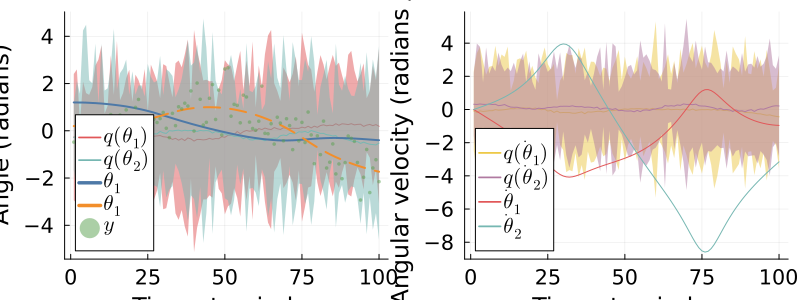

In [554]:
_, sym2range = bijector(tgmodel, Val(true));
dist = results.dist
sym2range
sranges = sym2range[:s]
ms = mean(dist)
vs = diag(cov(dist))

posteriors = []
for t in 1:T
    range = sranges[t]
    m = ms[range]
    v = vs[range]
    push!(posteriors, ReactiveMP.MvNormalMeanCovariance(m, Diagonal(v)))
end
    
em = mean.(posteriors)
ev = std.(posteriors)

p1 = plot(xlabel = "Time step index", ylabel = "Angle (radians)"; pfontsettings...)

plot!(prange, getindex.(em, 1)[prange], color = colors[3], ribbon = 3getindex.(ev, 1, 1), label = L"q(\theta_1)")
plot!(prange, getindex.(em, 2)[prange], color = colors[4], ribbon = 3getindex.(ev, 2, 2), label = L"q(\theta_2)")
plot!(prange, getindex.(states, 1)[prange], label = L"\theta_1", color = colors[1], linewidth = 2,)
plot!(prange, getindex.(states, 2)[prange], label = L"\theta_1", color = colors[2], linewidth = 2, style = :dash)
scatter!(prange, getindex.(observations, 1)[prange], ms = 2, msw = 0, alpha = 0.5, color = colors[5], label = L"y")

p2 = plot(size=(800, 300), xlabel = "Time step index", ylabel = "Angular velocity (radians / s)"; pfontsettings...)
plot!(prange, getindex.(em, 3)[prange], ribbon = 3getindex.(ev, 3, 3), color = colors[6], label = L"q(\dot{\theta}_1)")
plot!(prange, getindex.(em, 4)[prange], ribbon = 3getindex.(ev, 4, 4), color = colors[7], label = L"q(\dot{\theta}_2)")
plot!(prange, getindex.(states, 3)[prange], color = colors[3], label = L"\dot{\theta}_1")
plot!(prange, getindex.(states, 4)[prange], color = colors[4], label = L"\dot{\theta}_2")

plot(p1, p2, size = (800, 300), layout = @layout([ a b ]))